
# Tinkoff sirius ML 2023 RecSys intro task (–ú–æ–¥–µ–ª–∏)

‚ùó –ß—Ç–æ–±—ã –∫–æ–¥, –ø—Ä–∏–≤–µ–¥–µ–Ω–Ω—ã–π —Ä–∞–±–æ—Ç–∞–ª –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ, —á—Ç–æ–±—ã –±—ã–ª–∏ featured –¥–∞–Ω–Ω—ã–µ. –ò—Ö –º–æ–∂–Ω–æ –ø–æ–ª—É—á–∏—Ç—å –ª–∏–±–æ –≤ —Ä–µ–ø–æ–∑–∏—Ç–æ—Ä–∏–∏, –ª–∏–±–æ –∑–∞–ø—É—Å—Ç–∏—Ç—å EDA.ipynb –∏ –æ–Ω–∏ —Å–≥–µ–Ω–µ—Ä—É—Ä—é—Ç—Å—è —Å–∞–º–∏.

### –ë–∏–±–∏–ª–∏–æ—Ç–µ–∫–∏, –¥–∞–Ω–Ω—ã–µ, –º–µ—Ç—Ä–∏–∫–∏, –∫–ª–∞—Å—Å –¥–ª—è –Ω–∞—Å–ª–µ–¥–æ–≤–∞–Ω–∏—è

In [1]:
!pip install implicit >> /dev/null

In [45]:
from abc import ABC, abstractmethod
from typing import Dict, List
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import implicit
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ParameterGrid, train_test_split

In [3]:
data_folder = 'kion_data_featured/'

users_df = pd.read_csv(data_folder + 'users.csv')
items_df = pd.read_csv(data_folder + 'items.csv')
train_part = pd.read_csv(data_folder + 'train.csv', parse_dates=["last_watch_dt"])
test_part = pd.read_csv(data_folder + 'test_data.csv')
test_part = test_part.groupby("user_id").agg({"ground_truth": list}).reset_index()

In [4]:
 # https://github.com/deethereal/tinkoff-sirius-ml-2023-recsys-intro-task/blob/main/intro_task.ipynb
 # ACHTUNG! DO NOT TOUCH

def ndcg_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)
    if rank_dcg == 0.0:
        return 0.0

    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores: np.ndarray) -> float:
    return np.sum(
        np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)), dtype=np.float64
    )


def recall_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    n_gt = len(gt_items)
    intersection = len(set(gt_items).intersection(set(predicted)))
    return intersection / n_gt


def evaluate_recommender(df: pd.DataFrame, model_preds_col: str, gt_col: str = "ground_truth") -> Dict[str, float]:
    metric_values = []

    for _, row in df.iterrows():
        metric_values.append(
            (ndcg_metric(row[gt_col], row[model_preds_col]), recall_metric(row[gt_col], row[model_preds_col]))
        )

    return {"ndcg": np.mean([x[0] for x in metric_values]), "recall": np.mean([x[1] for x in metric_values])}

In [5]:
# https://github.com/deethereal/tinkoff-sirius-ml-2023-recsys-intro-task/blob/main/intro_task.ipynb
class BaseRecommender(ABC):
    def __init__(self):
        self.trained = False

    @abstractmethod
    def fit(self, df: pd.DataFrame) -> None:
        # —Ä–µ–∞–ª–∏–∑–∞—Ü–∏—è –º–æ–∂–µ—Ç –±—ã—Ç—å –ª—é–±–æ–π, –Ω–∏–∫–∞–∫–∏—Ö –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–∏–π

        # –Ω–µ –∑–∞–±—É–¥—å—Ç–µ –ø—Ä–æ
        self.trained = True

    @abstractmethod
    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        # —Ä–µ–∞–ª–∏–∑–∞—Ü–∏—è –º–æ–∂–µ—Ç –±—ã—Ç—å –ª—é–±–æ–π, –ù–û
        # –¥–æ–ª–∂–µ–Ω –≤–æ–∑–≤—Ä–∞—â–∞—Ç—å —Å–ø–∏—Å–æ–∫ –º–∞—Å—Å–∏–≤–æ–≤ –∏–∑ item_id, –∫–æ—Ç–æ—Ä—ã–µ –µ—Å—Ç—å –≤ `item_df`, —á—Ç–æ–±—ã –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ —Ä–∞–±–æ—Ç–∞–ª –ø–æ–¥—Å—á–µ—Ç –º–µ—Ç—Ä–∏–∫
        pass

## C—Ç–∞—Ç–∏—Å—Ç–∏—á–µ—Å–∫–∏ –ø–æ–¥—Ö–æ–¥—ã

### –¢–æ–ø –ø–æ–ø—É–ª—è—Ä–Ω—ã—Ö (Baseline)

In [6]:
# https://github.com/deethereal/tinkoff-sirius-ml-2023-recsys-intro-task/blob/main/intro_task.ipynb
class TopPopular(BaseRecommender):
    def __init__(self):
        super().__init__()

    def fit(self, df: pd.DataFrame, item_id_col: str = "item_id") -> None:
        # —Å—á–∏—Ç–∞–µ–º –ø–æ–ø—É–ª—è—Ä–Ω–æ—Å—Ç—å –∞–π—Ç–µ–º–æ–≤
        self.recommendations = df[item_id_col].value_counts().index.values
        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> np.ndarray:
        assert self.trained
        # –≤–æ–∑–≤—Ä–∞—â–∞–µ–º –¥–ª—è –≤—Å–µ—Ö –æ–¥–Ω–æ –∏ —Ç–æ –∂–µ
        return [self.recommendations[:topn]] * len(df)


toppop = TopPopular()
toppop.fit(train_part)
test_part["toppopular_recs"] = toppop.predict(test_part)
evaluate_recommender(df=test_part, model_preds_col="toppopular_recs")

{'ndcg': 0.17037237918248196, 'recall': 0.0763696799665908}

### –¢–æ–ø –ø–æ–ø—É–ª—è—Ä–Ω—ã—Ö –¥–ª—è —Ä–∞–∑–Ω—ã—Ö –∫–∞—Ç–µ–≥–æ—Ä–∏–π

–í–æ –≤—Ä–µ–º—è EDA –º—ã –≤—ã–¥–µ–ª–∏–ª–∏ –Ω–æ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –¥–ª—è —Ñ–∏–ª—å–º–æ–≤, –∞ –∏–º–µ–Ω–Ω–æ: –∫–∞–∫–æ–≥–æ –ø–æ–ª–∞ —á–µ–ª–æ–≤–µ–∫–∞ —á–∞—â–µ –ø—Ä–æ—Å—Å–º–∞—Ç—Ä–∏–≤–∞–µ—Ç —Ñ–∏–ª—å–º, –∫–∞–∫–æ–≥–æ –≤–æ–∑—Ä–∞—Å—Ç–∞ –∏ –¥–æ—Ö–æ–¥–∞. –≠—Ç–∏ –ø—Ä–∏–∑–Ω–∞–∫–∏ –±—É–¥–µ–º –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –¥–ª—è —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–π. –î–ª—è –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π, –ø—Ä–æ –∫–æ—Ç–æ—Ä—ã—Ö –º—ã –Ω–∏—á–µ–≥–æ –Ω–µ –∑–Ω–∞–µ–º (–æ–Ω–∏ –µ—Å—Ç—å –≤ train_part, –Ω–æ –∏—Ö –Ω–µ—Ç –≤ users_df) - –±—É–¥–µ–º —Ä–µ–∫–æ–º–µ–Ω–¥–æ–≤–∞—Ç—å –ø–æ–ø—É–ª—è—Ä–Ω—ã–µ.

In [7]:
class CategoryTopPopularRecommender(BaseRecommender):
    def __init__(self, category: str):
        super().__init__()
        self.cat_popularity = None
        self.trained = False
        self.top_popular_items = None
        self.category = category

    def fit(self, train_part: pd.DataFrame, users_df: pd.DataFrame, items_df: pd.DataFrame,
            item_id_col = 'item_id', views_col = 'views', user_id_col='user_id'):
        # –í—ã—á–∏—Å–ª—è–µ–º –æ–±—â–∏–π —Å–ø–∏—Å–æ–∫ –ø–æ–ø—É–ª—è—Ä–Ω—ã—Ö —Ñ–∏–ª—å–º–æ–≤ –ø–æ –≤—Å–µ –∑–Ω–∞—á–µ–Ω–∏—è–º –∫–∞—Ç–µ–≥–æ—Ä–∏–∏
        self.top_popular_items = items_df[[item_id_col, views_col]]\
                                  .sort_values(views_col, ascending=False)[item_id_col].to_list()

        # –ì—Ä—É–ø–ø–∏—Ä—É–µ–º 'items_df' –ø–æ –∫–∞—Ç–µ–≥–æ—Ä–∏–∏ –∏ —Å–æ—Ä—Ç–∏—Ä—É–µ–º —Ñ–∏–ª—å–º—ã –ø–æ –ø–æ–ø—É–ª—è—Ä–Ω–æ—Å—Ç–∏ (–∫–æ–ª–æ–Ω–∫–∞ 'views')
        self.cat_popularity = dict(train_part.merge(users_df, how='left', on=user_id_col)[[self.category, item_id_col]]\
                                   .groupby(self.category)[item_id_col]\
                                   .apply(lambda x: x.value_counts().index.tolist()))


        self.trained = True

    def predict(self, test_part: pd.DataFrame, users_df: pd.DataFrame, user_id_col = 'user_id', topn=10):
        assert self.trained

        # –û–±—ä–µ–¥–∏–Ω—è–µ–º 'test_part' —Å 'users_df' –ø–æ 'user_id' –∏ –æ—Å—Ç–∞–≤–ª—è–µ–º —Ç–æ–ª—å–∫–æ 'user_id' –∏ –∫–∞—Ç–µ–≥–æ—Ä–∏—é
        user_data = users_df[[user_id_col, self.category]]
        test_data = test_part.merge(user_data, on='user_id', how='left')

        # –°–æ–∑–¥–∞–µ–º –ø—É—Å—Ç–æ–π —Å—Ç–æ–ª–±–µ—Ü 'recommendations' –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–π
        test_data['recommendations'] = None

        # –î–ª—è –∫–∞–∂–¥–æ–π —Å—Ç—Ä–æ–∫–∏ –≤ test_data –≤—ã—á–∏—Å–ª—è–µ–º —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏
        for index, row in test_data.iterrows():
            cat = row[self.category]
            if cat in self.cat_popularity:
                recommendations = self.cat_popularity[cat][:topn]
            # –ï—Å–ª–∏ –º—ã –Ω–∏—á–µ–≥–æ –Ω–µ –∑–Ω–∞–µ–º –ø—Ä–æ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è, —Ç–æ —Ä–µ–∫–æ–º–µ–Ω–¥—É–µ–º –ø–æ–ø—É–ª—è—Ä–Ω–æ–µ
            else:
                recommendations = self.top_popular_items[:topn]

            test_data.at[index, 'recommendations'] = recommendations

        # –í–æ–∑–≤—Ä–∞—â–∞–µ–º —Å—Ç–æ–ª–±–µ—Ü 'recommendations' —Å —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏—è–º–∏
        return test_data['recommendations']

for cat in ['sex', 'income', 'age']:
    recommender = CategoryTopPopularRecommender(cat)
    recommender.fit(train_part, users_df, items_df)
    test_part[cat + "_recs"] = recommender.predict(test_part, users_df)
    print(f'–†–∞–∑–∏–±–µ–Ω–∏–µ –ø–æ {cat}: ', evaluate_recommender(df=test_part, model_preds_col=cat + "_recs"))

–†–∞–∑–∏–±–µ–Ω–∏–µ –ø–æ sex:  {'ndcg': 0.1712007695565208, 'recall': 0.07668173604995636}
–†–∞–∑–∏–±–µ–Ω–∏–µ –ø–æ income:  {'ndcg': 0.17148589785741739, 'recall': 0.07695524790918498}
–†–∞–∑–∏–±–µ–Ω–∏–µ –ø–æ age:  {'ndcg': 0.17224145285241338, 'recall': 0.07724899822276024}


–í–∏–¥–∏–º, —á—Ç–æ —Ä–∞–∑–±–∏–µ–Ω–∏–µ –ø–æ –∫–∞—Ç–µ–≥–æ—Ä–∏—è–º —Ä–∞–±–æ—Ç–∞–µ—Ç –Ω–µ–º–Ω–æ–≥–æ –ª—É—á—à–µ, —á–µ–º –±–µ–π–∑–ª–∞–π–Ω.

## –ö–ª–∞—Å—Å–∏—á–µ—Å–∫–∏–µ –º–µ—Ç–æ–¥—ã (Implicit)



–°–æ–∑–¥–∞–¥–∏–º –∫–ª–∞—Å—Å –¥–ª—è —Ä–∞–±–æ—Ç—ã —Å implicit, –¥–ª—è —Ç–æ–≥–æ —á—Ç–±—ã –Ω–µ –ø–æ–≤—Ç–æ—Ä—è—Ç—å –∫–æ–¥. –û—Ç –Ω–µ–≥–æ –±—É–¥–µ–º —Å–æ–∑–¥–∞–≤–∞—Ç—å –≤—Å–µ implicit –º–æ–¥–µ–ª–∏.

In [8]:
# https://github.com/deethereal/tinkoff-sirius-ml-2023-recsys-intro-task/blob/main/intro_task.ipynb

# –ò–∑–Ω–∞—á–∞–ª—å–Ω–æ —è –Ω–∞–ø–∏—Å–∞–ª —Å–≤–æ—é —Ä–µ–∞–ª–∏–∑–∞—Ü–∏—é –∫–ª–∞—Å—Å–∞, –æ–Ω–∞ –ø–æ–ª—É—á–∏–ª–æ—Å—å —Å–ª–æ–∂–Ω–æ–π –∏ –∑–∞–ø—É—Ç–∞–Ω–Ω–æ–π,
# –ø–æ—ç—Ç–æ–º—É —Ä–µ—à–∏–ª –ø–æ–∑–∞–∏–º—Å—Ç–≤–æ–≤–∞—Ç—å —Ä–µ–∞–ª–∏–∑–≤–∞—Ü–∏—é –∏–∑ —É—Å–ª–æ–≤–∏—è –∑–∞–¥–∞–Ω–∏—è

class ImplicitBaseRecommender(BaseRecommender):
    def __init__(self, model=None, **kwargs) -> None:
        super().__init__()
        self.params = kwargs
        self.model = model(**kwargs)
        self.trained = False

    def fit(
        self, df: pd.DataFrame, item_col: str = "item_id", user_col: str = "user_id", value_col: str = None
    ) -> None:
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        user_ids = self.user_encoder.fit_transform(df[user_col])
        item_ids = self.item_encoder.fit_transform(df[item_col])
        if value_col is None:
            counts = np.ones(len(df))
        else:
            counts = df[value_col].values

        matrix_shape = len(self.user_encoder.classes_), len(self.item_encoder.classes_)

        self.sparse = csr_matrix((counts, (user_ids, item_ids)), shape=matrix_shape)
        self.model.fit(self.sparse)

        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        assert self.trained

        all_recs = []

        users = self.user_encoder.transform(df["user_id"])
        for user in tqdm(users, desc="predicting", leave=False):
            encoded_rec_items = self.model.recommend(user, user_items=self.sparse[user], N=topn)[0]
            all_recs.append(self.item_encoder.inverse_transform(encoded_rec_items))

        return all_recs

    # –ú–µ—Ç–æ–¥, –∫–æ—Ç–æ—Ä—ã–π –≤–æ–∑–≤—Ä–∞—â–∞–µ—Ç df –¥–ª—è –º–æ–¥–µ–ª–∏ –≤—Ç–æ—Ä–æ–≥–æ —É—Ä–æ–≤–Ω—è
    def get_df_recs(self, df: pd.DataFrame, topn: int = 50,
                    user_id_col: str ='user_id', item_id_col: str = 'item_id'
    ) -> pd.DataFrame:
        assert self.trained

        df['recs'] = self.predict(first_level_test, topn)
        df = df.explode('recs', ignore_index=True)
        df['rank'] = df.groupby([user_id_col, item_id_col]).cumcount() + 1
        return df

    # –¥–≤–∞ –º–µ—Ç–æ–¥–∞, —á—Ç–æ–±—ã –ø—Ä–∞–≤–∏–ª—å–Ω–æ —Ä–∞–±–æ—Ç–∞–ª –ø–æ–¥–±–æ—Ä –≥–∏–ø–ø–µ—Ä –ø–∞—Ä–∞–º–∞—Ç–µ—Ä–æ–≤ —á–µ—Ä–µ–∑ –∫—Ä–æ—Å—Å–≤–∞–ª–∏–¥–∞—Ü–∏—é –∏–∑ sklearn
    # https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html
    # –í –∏—Ç–æ–≥–µ –±—ã–ª–æ –ø—Ä–∏–Ω—è—Ç–æ —Ä–µ—à–µ–Ω–∏–µ –æ—Ç–∫–∞–∑–∞—Ç—å—Å—è –æ—Ç –ø–æ–¥–±–æ—Ä–∞ –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ c –ø–æ–º–æ—â—å—é k-fold cv –ø–æ–¥—Ä–æ–±–Ω–µ–µ –Ω–∏–∂–µ
    def set_params(self, **params):
        self.model = self.model(**params)
        return self

    def get_params(self, deep=True):
        return {**self.params}

### kNN

In [9]:
knn_rec = ImplicitBaseRecommender(model=implicit.nearest_neighbours.CosineRecommender,
                                  K=15_000)
knn_rec.fit(train_part)
test_part["knn_recs"] = knn_rec.predict(test_part)

/home/gr/.config/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.011188983917236328 seconds
  warnings.warn(


  0%|          | 0/12067 [00:00<?, ?it/s]

predicting:   0%|          | 0/18693 [00:00<?, ?it/s]

In [10]:
evaluate_recommender(test_part, model_preds_col="knn_recs")

{'ndcg': 0.12234769080835413, 'recall': 0.054391934978456756}

–í–∏–¥–∏–º, —á—Ç–æ –∫–∞—á–µ—Å—Ç–≤–æ –ø—Ä–æ—Å–µ–ª–æ –¥–∞–∂–µ –ø–æ —Å—Ä–∞–≤–Ω–µ–Ω–∏—é —Å –±–µ–π–∑–ª–∞–π–Ω–æ–º.

### TFIDF

In [11]:
tfidf_rec = ImplicitBaseRecommender(model=implicit.nearest_neighbours.TFIDFRecommender,
                                    K=15_000)
tfidf_rec.fit(train_part)
test_part["tfidf_recs"] = tfidf_rec.predict(test_part)

/home/gr/.config/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.01186370849609375 seconds
  warnings.warn(


  0%|          | 0/12067 [00:00<?, ?it/s]

predicting:   0%|          | 0/18693 [00:00<?, ?it/s]

In [12]:
evaluate_recommender(test_part, model_preds_col="tfidf_recs")

{'ndcg': 0.12740156038704564, 'recall': 0.05658684677730701}

–ê–Ω–∞–ª–æ–≥–∏—á–Ω–∞—è –∫–∞—Ä—Ç–∏–Ω–∞.

### Item to item

In [13]:
itemitem_rec = ImplicitBaseRecommender(model=implicit.nearest_neighbours.ItemItemRecommender,
                                       K=15_000)
itemitem_rec.fit(train_part)
test_part["itemitem_recs"] = itemitem_rec.predict(test_part)

  0%|          | 0/12067 [00:00<?, ?it/s]

predicting:   0%|          | 0/18693 [00:00<?, ?it/s]

In [14]:
evaluate_recommender(test_part, model_preds_col="itemitem_recs")

{'ndcg': 0.191239213767931, 'recall': 0.08579517402016573}

Item to Item —Å—Ä–∞–±–æ—Ç–∞–ª —É–∂–µ –ª—É—á—à–µ, —á–µ–º —Ä–∞–∑–¥–µ–ª–µ–Ω–∏–µ –Ω–∞ –∫–∞—Ç–µ–≥–æ—Ä–∏–∏. –ù–æ –∏ —ç—Ç–æ—Ç —Ä–µ–∑—É–ª—å—Ç–∞—Ç –ø–æ–ø—Ä–æ–±—É–µ–º —É–ª—É—á—à–∏—Ç—å.

## –ë–æ–ª–µ–µ —Å–ª–æ–∂–Ω—ã–µ –º–æ–¥–µ–ª–∏ –∏ –∏—Ö —Ç—é–Ω–∏–Ω–≥

–í ALS (–∏ –≤ –º–æ–¥–µ–ª—è—Ö —Ä–∞—Å—Å–º–æ—Ç—Ä–µ–Ω–Ω—ã—Ö –¥–∞–ª—å—à–µ) —É–∂–µ –º–Ω–æ–≥–æ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤, –∏ –ø—Ä–æ—Å—Ç–æ–µ —É–≤–µ–ª–∏—á–µ–Ω–∏–µ —ç—Ç–∏—Ö –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –Ω–µ –ø—Ä–∏–≤–µ–¥–µ—Ç –∫ —É–≤–µ–ª–∏—á–µ–Ω–∏—é –∫–∞—á–µ—Å—Ç–≤–∞ (–∫–∞–∫ –±—ã–ª–æ —Å –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ–º —Å–æ—Å–µ–¥–µ–π). –ü–æ—ç—Ç–æ–º—É –Ω–∞–º –Ω—É–∂–Ω–æ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –∫—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏—é –¥–ª—è –ø–æ–¥–±–æ—Ä–∞ —ç—Ç–∏—Ö –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤.

–î–∞–ª–µ–µ —è —Å—Ç–æ–ª–∫–Ω—É–ª—Å—è —Å –ø—Ä–æ–±–ª–µ–º–æ–π: –µ—Å–ª–∏ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å k-fold –∫—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏—é, —Ç–æ —Å–ª–∏—à–∫–æ–º –º–Ω–æ–≥–æ –¥–∞–Ω–Ω—ã—Ö –±—É–¥–µ—Ç –≤ —Ç–µ—Å—Ç–æ–≤–æ–π —á–∞—Å—Ç–µ, –∫–∞–∫ —Å–ª–µ–¥—Å—Ç–≤–∏–µ, –º–æ–¥–µ–ª—å –Ω–µ —Å–º–æ–∂–µ—Ç —Ö–æ—Ä–æ—à–æ –æ–±—É—á–∏—Ç—å—Å—è. –≠—Ç—É –ø—Ä–æ–±–ª–µ–º—É –º–æ–∂–Ω–æ —Ä–µ—à–∏—Ç—å, –µ—Å–ª–∏ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –±–æ–ª—å—à–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ñ–æ–ª–¥–æ–≤, –ª–∏–±–æ –≤–æ–æ–±—â–µ leave-one-out, –Ω–æ —É –º–µ–Ω—è –Ω–µ—Ç —Ç–∞–∫–∏—Ö –º–æ—â–Ω–æ—Å—Ç–µ–π. *(–ü–æ –º–æ–∏–º –ø–æ–¥—Å—á–µ—Ç–∞–º –Ω–∞ 50 —Ñ–æ–ª–¥–æ–≤ –∏ 25 –Ω–∞–±–æ—Ä–æ–≤ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –Ω—É–∂–Ω–æ –ø—Ä–∏–º–µ—Ä–Ω–æ 8 —á–∞—Å–æ–≤ —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º gpu)*

–ë—É–¥–µ–º –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –ø—Ä–æ—Å—Ç–æ Hold-out –≤–∞–ª–∏–¥–∞—Ü–∏—é –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–µ.

---
https://datascience.stackexchange.com/questions/6814/how-to-split-train-test-in-recommender-systems

https://academy.yandex.ru/handbook/ml/article/kross-validaciya

https://github.com/anamarina/RecSys_course



–ë—É–¥–µ–º –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å gpu, —ç—Ç–æ —Å—ç–∫–æ–Ω–æ–º–∏—Ç –∫—É—á—É –≤—Ä–µ–º–µ–Ω–∏. –ü—Ä–æ–≤–µ—Ä–∏–º cuda. (–ü–æ–∑–∂–µ —è –ø–µ—Ä–µ–∑–∞–ø—É—Å–∫–∞–ª –Ω–æ—É—Ç–±—É–∫ –Ω–µ –≤ –∫–æ–ª–∞–±–µ, –∞ –Ω–∞ —Å–≤–æ–µ–º –∫–æ–º–ø—å—é—Ç–µ—Ä–µ, –≤ –∫–æ—Ç–æ—Ä–æ–º –Ω–µ—Ç –≤–∏–¥–µ–æ–∫–∞—Ä—Ç—ã)

In [15]:
!nvidia-smi

fish: Unknown command: nvidia-smi
fish: 
nvidia-smi
^~~~~~~~~^


–†–µ–∞–ª–∏–∑—É–µ–º —Ñ—É–Ω–∫—Ü–∏—é –¥–ª—è –≤–∞–ª–∏–¥–∞—Ü–∏–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤, –∏—Å–ø–æ–ª—å–∑—É—é—â—É—é Hold Out –≤–∞–ª–∏–¥–∞—Ü–∏—é.

In [28]:
# https://tqdm.github.io/
# https://github.com/scikit-learn/scikit-learn/blob/7f9bad99d/sklearn/model_selection/_search.py#L50

# –ü—Ä–æ —Ä–µ–∞–ª–∏–∑–æ–≤–∞–Ω–Ω—É—é —Ñ—É–Ω–∫—Ü–∏—é len() —É–∑–Ω–∞–ª –∏–∑ –∏—Å—Ö–æ–¥–Ω–æ–≥–æ –∫–æ–¥–∞, –≤ –¥–æ–∫—É–º–µ–Ω—Ç–∞—Ü–∏–∏ –ø—Ä–æ –Ω–µ—ë –Ω–∏—á–µ–≥–æ –Ω–µ—Ç
# —Ñ—É–Ω–∫—Ü–∏—é len() –≤—ã–∑—ã–≤–∞–µ—Ç tqdm
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html#sklearn.model_selection.ParameterGrid

def ImplicitHoldOutCV(model: ImplicitBaseRecommender,
              train_part: pd.DataFrame, test_part: pd.DataFrame,
              params: dict) -> tuple :
    param_grid = ParameterGrid(params)

    best_model = None
    best_params: dict = None
    best_score: dict[str, int] = {'ndcg': 0, 'recall': 0}

    for params in tqdm(param_grid):
        rec_model = ImplicitBaseRecommender(model=model, **params)
        rec_model.fit(train_part)
        test_part["recs"] = rec_model.predict(test_part)
        score = evaluate_recommender(test_part, model_preds_col="recs")
        if score['ndcg'] > best_score['ndcg'] \
                and score['recall'] > best_score['recall']:
            best_score = score
            best_model = rec_model
            best_params = params

    return best_model, best_params, best_score

–í—ã–¥–µ–ª–∏–º –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω—É—é –≤—ã–±–æ—Ä–∫—É. 80% –∏—Å—Ö–æ–¥–Ω–æ–π —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–∏ –ø–æ–π–¥—É—Ç –≤ —Ç—Ä–µ–π–Ω, 20% –≤ —Ç–µ—Å—Ç. –í —Ç–µ—Å—Ç–µ —Ç–∞–∫ –∂–µ –≤—ã–±–µ—Ä–µ–º —Ç–æ–ª—å–∫–æ —Ç–µ—Ö, –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π, –∫–æ—Ç–æ—Ä—ã–µ –≤—Å—Ç—Ä–µ—á–∞–ª–∏—Å—å —Ä–∞–Ω–µ–µ –∏ —É –∫–æ—Ç–æ—Ä—ã—Ö –±–æ–ª—å—à–µ 2 –ø—Ä–æ—Å–º–æ—Ç—Ä–æ–≤.

In [29]:
train_part = train_part.sample(frac=1).reset_index(drop=True)


train_part_v = train_part.iloc[int(len(train_part) / 5):]


test_part_v = train_part.iloc[:int(len(train_part) / 5)]

# –û—Å—Ç–∞–≤–∏–º —Ç–æ–ª—å–∫–æ —Ç–µ—Ö –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π, –∫–æ—Ç–æ—Ä—ã–µ –±—ã–ª–∏ –≤ —Ç—Ä–µ–π–Ω–µ
test_part_v = test_part_v[test_part_v['user_id'].isin(train_part_v['user_id'].unique())]

test_part_v = test_part_v[['user_id', 'item_id']]
test_part_v = test_part_v.groupby('user_id', as_index=False).agg(list)

# –û—Å—Ç–∞–≤–∏–º —Ç–æ–ª—å–∫–æ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π —Å –±–æ–ª–µ–µ, —á–µ–º 2 –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏—è–º–∏
test_part_v = test_part_v[test_part_v['item_id'].apply(len) > 2]
test_part_v = test_part_v.rename(columns={'item_id':'ground_truth'})

### ALS

In [30]:
# –ü–∞—Ä–∞–º–µ—Ç—Ä—ã, –∫–æ—Ç–æ—Ä—ã–µ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–ª–∏—Å—å –∏–∑–Ω–∞—á–∞–ª—å–Ω–æ
# params = {
#         'factors': [1, 2, 3],
#         'regularization': [0.01, 0.02],
#         'alpha': [0.1, 0.075, 0.125],
#         'iterations': [1, 2, 5, 10, 15],
#         'random_state': [42]
# }


# –õ—É—á—à–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã
params = {
    'alpha': [0.001],
    'factors': [1],
    'iterations': [5],
    'random_state': [42],
    'regularization': [0.01]
}

# model = implicit.gpu.als.AlternatingLeastSquares
model = implicit.cpu.als.AlternatingLeastSquares

best_als_model, best_als_params, best_als_score = ImplicitHoldOutCV(model,
                                                                train_part_v,
                                                                test_part_v,
                                                                params)

# –û–±—É—á–∞–µ–º –ª—É—á—à—É—é –º–æ–¥–µ–ª—å —É–∂–µ –Ω–∞ –≤—Å–µ—Ö –¥–∞–Ω–Ω—ã—Ö
best_als_model = ImplicitBaseRecommender(model, **best_als_params)
best_als_model.fit(train_part)
test_part["als_recs"] = best_als_model.predict(test_part)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

predicting:   0%|          | 0/15840 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

predicting:   0%|          | 0/18693 [00:00<?, ?it/s]

In [31]:
evaluate_recommender(test_part, model_preds_col="als_recs")

{'ndcg': 0.18147419856444427, 'recall': 0.0822750659878154}

Item to item –º—ã –Ω–µ –ø—Ä–µ–≤–∑–æ—à–ª–∏, –Ω–æ –ª—É—á—à–µ —á–µ–º –±–µ–π–∑–ª–∞–π–Ω –∏ —Ç–æ–ø –ø–æ–ø—É–ª—è—Ä–Ω—ã—Ö –ø–æ –∫–∞—Ç–µ–≥–æ—Ä–∏—è–º.

### BPR


In [32]:
# –ü–∞—Ä–∞–º–µ—Ç—Ä—ã, –∫–æ—Ç–æ—Ä—ã–µ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–ª–∏—Å—å –∏–∑–Ω–∞—á–∞–ª—å–Ω–æ
# params = {
#         'factors': [100, 300, 400, 600],
#         'regularization': [0.01, 0.02, 0.05, 0.075],
#         'learning_rate': [0.001, 0.01, 0.075],
#         'iterations': [10, 25, 30, 40],
#         'random_state': [42]
# }


# –õ—É—á—à–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã
params = {
         'factors': [400],
         'iterations': [10],
         'learning_rate': [0.001],
         'random_state': [42],
         'regularization': [0.05]
}

# model = implicit.gpu.bpr.BayesianPersonalizedRanking
model = implicit.cpu.bpr.BayesianPersonalizedRanking

best_bpr_model, best_bpr_params, best_bpr_score = ImplicitHoldOutCV(model,
                                                                train_part_v,
                                                                test_part_v,
                                                                params)

# –û–±—É—á–∞–µ–º –ª—É—á—à—É—é –º–æ–¥–µ–ª—å —É–∂–µ –Ω–∞ –≤—Å–µ—Ö –¥–∞–Ω–Ω—ã—Ö
best_bpr_model = ImplicitBaseRecommender(model, **best_bpr_params)
best_bpr_model.fit(train_part)
test_part["bpr_recs"] = best_bpr_model.predict(test_part)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

predicting:   0%|          | 0/15840 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

predicting:   0%|          | 0/18693 [00:00<?, ?it/s]

In [33]:
evaluate_recommender(test_part, model_preds_col="bpr_recs")

{'ndcg': 0.06347402724046615, 'recall': 0.02499264789262535}

–ü–ª–æ—Ö–æ–µ –∫–∞—á–µ—Å—Ç–≤–æ.

### LMF

In [34]:
# –ü–∞—Ä–∞–º–µ—Ç—Ä—ã, –∫–æ—Ç–æ—Ä—ã–µ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–ª–∏—Å—å –∏–∑–Ω–∞—á–∞–ª—å–Ω–æ
# params = {
#         'factors': [30, 40, 50, 70, 80],
#         'regularization': [0.1, 0.2, 0.5, 0.75, 1],
#         'learning_rate': [0.001, 0.01, 0.075, 0.125],
#         'iterations': [40, 50, 80, 100],
#         'neg_prop' : [5, 10, 30, 50],
#         'random_state': [42]
# }


# –õ—É—á—à–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã
params = {'factors': [40],
         'iterations': [300],
         'learning_rate': [0.3],
         'neg_prop': [5],
         'random_state': [42],
         'regularization': [1]
}

model = implicit.cpu.lmf.LogisticMatrixFactorization

best_lmf_model, best_lmf_params, best_lmf_score = ImplicitHoldOutCV(model,
                                                                train_part_v,
                                                                test_part_v,
                                                                params)

# –û–±—É—á–∞–µ–º –ª—É—á—à—É—é –º–æ–¥–µ–ª—å —É–∂–µ –Ω–∞ –≤—Å–µ—Ö –¥–∞–Ω–Ω—ã—Ö
best_lmf_model = ImplicitBaseRecommender(model, **best_bpr_params)
best_lmf_model.fit(train_part)
test_part["lmf_recs"] = best_lmf_model.predict(test_part)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

predicting:   0%|          | 0/15840 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

predicting:   0%|          | 0/18693 [00:00<?, ?it/s]

In [35]:
evaluate_recommender(test_part, model_preds_col="lmf_recs")

{'ndcg': 0.0023001168495965034, 'recall': 0.000791875314423862}

–î–æ–ª–≥–æ –∂–¥–∞—Ç—å –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è, –¥–∞ –∏ –∫–∞—á–µ—Å—Ç–≤–æ –ø—Ä–æ—Å—Ç–æ —É–∂–∞—Å–Ω–æ–µ.

## EDA —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–π

–î–∞–≤–∞–π—Ç–µ –ø–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ —Ç–æ, –∫–∞–∫ —Ä–æ—Å–ª–∏ –º–µ—Ç—Ä–∏–∫–∏ –≤ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –æ—Ç –º–æ–¥–µ–ª–∏.

In [36]:
columns = test_part.columns.to_list()[2:]
metrics = [evaluate_recommender(test_part, model_preds_col=pred_col) for pred_col in columns]

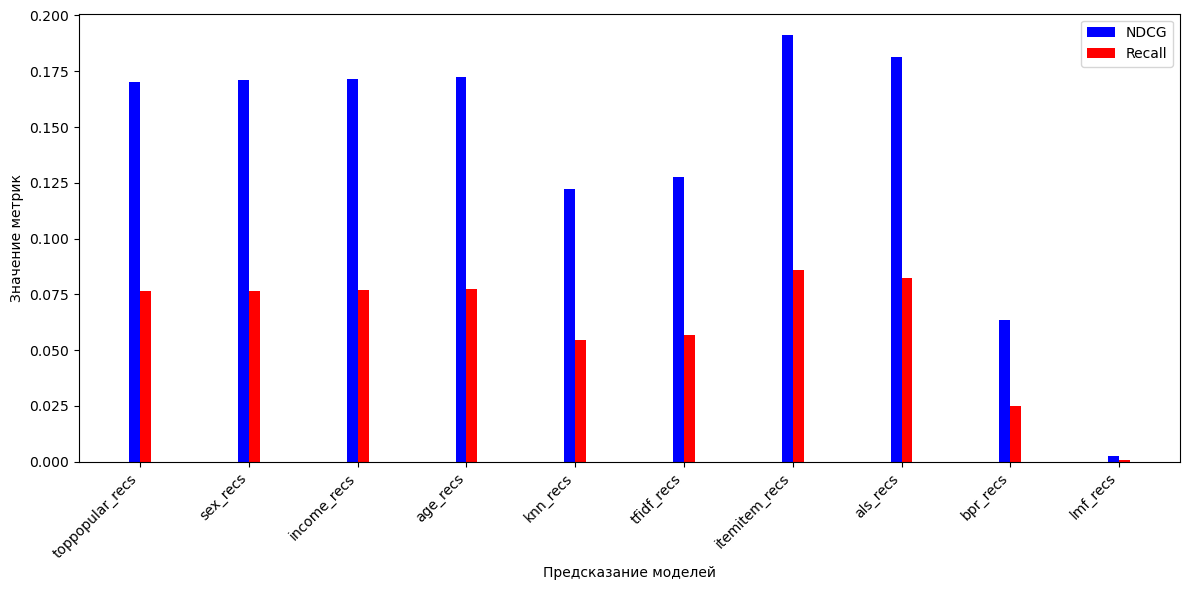

In [37]:
ndcg_values = [metric['ndcg'] for metric in metrics]
recall_values = [metric['recall'] for metric in metrics]

x = np.arange(len(columns))

bar_width = 0.1

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(x - bar_width/2, ndcg_values, 0.1, label='NDCG', color='blue')
ax.bar(x + bar_width/2, recall_values, bar_width, label='Recall', color='red')

ax.set_xticks(x)
ax.set_xticklabels(columns, rotation=45, ha='right')
ax.set_xlabel('–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ –º–æ–¥–µ–ª–µ–π')
ax.set_ylabel('–ó–Ω–∞—á–µ–Ω–∏–µ –º–µ—Ç—Ä–∏–∫')
ax.legend()
plt.tight_layout()
plt.show()

–í–∏–¥–∏–º, —á—Ç–æ –ª—É—á—à–∞—è –º–æ–¥–µ–ª—å —ç—Ç–æ item to item, —Å–ª–µ–¥—É—é—â–∞—è als.

–î–∞–≤–∞–π—Ç–µ –ø–æ—Å–º–æ—Ä–∏–º, —á—Ç–æ –Ω–∞–º —Ä–µ–∫–æ–º–µ–Ω–¥—É–µ—Ç –ª—É—á—à–∞—è –º–æ–¥–µ–ª—å. –ê –∏–º–µ–Ω–Ω–æ —Å–∞–º—ã–µ —á–∞—Å—Ç–æ –≤—Å—Ç—Ä–µ—á–∞–µ–º—ã–µ —Ñ–∏–ª—å–º—ã –≤—Å—Ç—Ä–µ—á–∞–µ–º—ã–π —Ñ–∏–ª—å–º.

In [38]:
top_item_item_recs = test_part['als_recs'].explode('als_recs').value_counts().keys().to_list()[:10]
top_items_als = items_df.loc[items_df['item_id'].isin(top_item_item_recs)]['title']
top_items_als

158                             –ê—Ñ–µ—Ä–∞
572                   –ö–ª–∏–Ω–∏–∫–∞ —Å—á–∞—Å—Ç—å—è
1429                      –•—Ä—É—Å—Ç–∞–ª—å–Ω—ã–π
4809                –ì–Ω–µ–≤ —á–µ–ª–æ–≤–µ—á–µ—Å–∫–∏–π
4921                         –î–µ–≤—è—Ç–∞–µ–≤
5064           –°–µ–∫—Ä–µ—Ç—ã —Å–µ–º–µ–π–Ω–æ–π –∂–∏–∑–Ω–∏
5522                            –ù–µ–º—Ü—ã
9137     –ü—Ä–∞–±–∞–±—É—à–∫–∞ –ª–µ–≥–∫–æ–≥–æ –ø–æ–≤–µ–¥–µ–Ω–∏—è
10305                      –ü–æ–¥—Å–ª—É—à–∞–Ω–æ
11506                            –ú–∞—à–∞
Name: title, dtype: object

–¢–µ–ø–µ—Ä—å –ø–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ —Ç–æ–ø –ø–æ–ø—É–ª—è–Ω—ã—Ö.

In [39]:
items_df.sort_values('views', ascending=False)['title'][:10]

1429                      –•—Ä—É—Å—Ç–∞–ª—å–Ω—ã–π
572                   –ö–ª–∏–Ω–∏–∫–∞ —Å—á–∞—Å—Ç—å—è
4921                         –î–µ–≤—è—Ç–∞–µ–≤
4809                –ì–Ω–µ–≤ —á–µ–ª–æ–≤–µ—á–µ—Å–∫–∏–π
5064           –°–µ–∫—Ä–µ—Ç—ã —Å–µ–º–µ–π–Ω–æ–π –∂–∏–∑–Ω–∏
10305                      –ü–æ–¥—Å–ª—É—à–∞–Ω–æ
9137     –ü—Ä–∞–±–∞–±—É—à–∫–∞ –ª–µ–≥–∫–æ–≥–æ –ø–æ–≤–µ–¥–µ–Ω–∏—è
158                             –ê—Ñ–µ—Ä–∞
11506                            –ú–∞—à–∞
2939                            –î—É—Ä–æ–≤
Name: title, dtype: object

–í–∏–¥–∏–º, —á—Ç–æ –ø–æ–ª—É—á–∞–µ–Ω–Ω–∞—è –º–æ–¥–µ–ª—å —Ä–µ–∫–æ–º–µ–Ω–¥—É–µ—Ç –ø–æ–ø—É–ª—è—Ä–Ω—ã–µ —Ñ–∏–ª—å–º—ã, –Ω–æ –≤ –¥—Ä—É–≥–æ–º –ø–æ—Ä—è–¥–∫–µ.


–ü–æ—Å–º–æ—Ç—Ä–∏–º, —á—Ç–æ —Ä–µ–∫–æ–º–µ–Ω–¥—É–µ—Ç—Å—è –∫ —Ç—Ä–µ–º —Å–∞–º—ã–º –ø–æ–ø—É–ª—è—Ä–Ω—ã–º —Ñ–∏–ª—å–º–∞–º.

In [40]:
print(f'–ö —Ñ–∏–ª—å–º—É: "{top_items_als.tolist()[0]}" –†–µ–∫–æ–º–µ–Ω–¥—É–µ—Ç—Å—è:', '\n')
similar_items = best_als_model.model.similar_items(top_item_item_recs[0], 5)[0].tolist()
items_df.loc[items_df['item_id'].isin(similar_items)]['title']

–ö —Ñ–∏–ª—å–º—É: "–ê—Ñ–µ—Ä–∞" –†–µ–∫–æ–º–µ–Ω–¥—É–µ—Ç—Å—è: 



3452          –ú—É–º–∏-–¥–æ–ª
7795     –ü–æ—Ä–æ–∂–Ω–∏–π —Ä–µ–π—Å
10386        –ü–æ—Ä—Ç—Ñ–æ–ª–∏–æ
Name: title, dtype: object

In [41]:
print(f'–ö —Ñ–∏–ª—å–º—É: "{top_items_als.tolist()[1]}" –†–µ–∫–æ–º–µ–Ω–¥—É–µ—Ç—Å—è:', '\n')
similar_items = best_als_model.model.similar_items(top_item_item_recs[1], 5)[0].tolist()
items_df.loc[items_df['item_id'].isin(similar_items)]['title']

–ö —Ñ–∏–ª—å–º—É: "–ö–ª–∏–Ω–∏–∫–∞ —Å—á–∞—Å—Ç—å—è" –†–µ–∫–æ–º–µ–Ω–¥—É–µ—Ç—Å—è: 



3124                    –¢—Ä–∏ –¥–Ω—è –Ω–∞ –ø–æ–±–µ–≥
7284         –≠—Å–ø–µ–Ω –≤ –∫–æ—Ä–æ–ª–µ–≤—Å—Ç–≤–µ —Ç—Ä–æ–ª–ª–µ–π
11203    –í–ª—é–±–ª–µ–Ω –ø–æ —Å–æ–±—Å—Ç–≤–µ–Ω–Ω–æ–º—É –∂–µ–ª–∞–Ω–∏—é
11522              –ì–ª–∞–≤–Ω–æ–µ ‚Äì –Ω–µ –±–æ—è—Ç—å—Å—è!
Name: title, dtype: object

In [42]:
print(f'–ö —Ñ–∏–ª—å–º—É: "{top_items_als.tolist()[2]}" –†–µ–∫–æ–º–µ–Ω–¥—É–µ—Ç—Å—è:', '\n')
similar_items = best_als_model.model.similar_items(top_item_item_recs[2], 5)[0].tolist()
items_df.loc[items_df['item_id'].isin(similar_items)]['title']

–ö —Ñ–∏–ª—å–º—É: "–•—Ä—É—Å—Ç–∞–ª—å–Ω—ã–π" –†–µ–∫–æ–º–µ–Ω–¥—É–µ—Ç—Å—è: 



985      –ù–∏–ª—å—Å–∫–∏–π –∫—Ä–æ–∫–æ–¥–∏–ª. –Æ–∂–Ω–∞—è –ê—Ñ—Ä–∏–∫–∞
1505                              –§–µ–Ω–∏–∫—Å
6376                          –ö–æ—Ä–ø–æ—Ä–∞—Ç–∏–≤
7979               257 –ø—Ä–∏—á–∏–Ω —á—Ç–æ–±—ã –∂–∏—Ç—å
10255              –ö–∞–∫ —Ä–∞–∑ –ø–æ–¥ –†–æ–∂–¥–µ—Å—Ç–≤–æ
Name: title, dtype: object

–§–∏–ª—å–º—ã –Ω–µ –ø–æ–≤—Ç–æ—Ä—è—é—Ç—Å—è - —ç—Ç–æ —Ö–æ—Ä–æ—à–æ. –ù–∞—à–∞ –º–æ–¥–µ–ª—å –Ω–µ —Å–∫–ª–æ–Ω–Ω–∞ —Ä–µ–∫–æ–º–µ–Ω–¥–æ–≤–∞—Ç—å —Ç–æ–ª—å–∫–æ –ø–æ–ø—É–ª—è—Ä–Ω–æ–µ.

## –ò—Ç–æ–≥

1. –ò—Å—Å–ª–µ–¥–æ–≤–∞–Ω—ã –º–æ–¥–µ–ª–∏ –Ω–∞ –æ—Å–Ω–æ–≤–µ –ø—Ä–æ—Å—Ç—ã—Ö —Ä–∞–∑–∏–±–µ–Ω–∏–π –∏ –Ω–∞ –æ—Å–Ω–æ–≤–µ –∫–ª–∞—Å—Å–∏—á–µ—Å–∫–∏—Ö –º–µ—Ç–æ–¥–æ–≤ –∏–∑ implicit.
2. –õ—É—á—à–µ–µ –∫–∞—á–µ—Å—Ç–≤–æ –ø–æ–ª—É—á–∏–ª–æ—Å—å –¥–ª—è item-item –º–æ–¥–µ–ª–∏ `ndcg: 0.191`, `recall: 0.086`.


–û—á–µ–Ω—å —Ö–æ—Ç–µ–ª, –Ω–æ –Ω–µ —É—Å–ø–µ–ª üòû —Ä–µ–∞–∏–ª–∑–æ–≤–∞—Ç—å –º–æ–¥–µ–ª—å –Ω–∞ –æ—Å–Ω–æ–≤–µ –±—É—Å—Ç–∏–Ω–≥–∞ –∏ –¥–≤—É—Ö—ç—Ç–∞–ø–Ω—É—é –º–æ–¥–µ–ª—å. –ù–∞ –ø–µ—Ä–≤–æ–º —É—Ä–æ–≤–Ω–µ –ª—É—á—à–∞—è –º–æ–¥–µ–ª—å –∏–∑ –ø—Ä–æ—Å—Ç—ã—Ö, –≤ –º–æ–µ–º —Å–ª—É—á–∞–µ —ç—Ç–æ item to item, –Ω–∞ –≤—Ç–æ—Ä–æ–º catboost, –∫–æ—Ç–æ—Ä—ã–π –∏—Å–ø–æ–ª—å–∑—É–µ—Ç –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –ø–µ—Ä–≤–æ–π –º–æ–¥–µ–ª–∏, –∫–∞–∫ —Ñ–∏—á–∏. –ò–º–µ–Ω–Ω–æ –¥–ª—è —ç—Ç–æ–≥–æ —è –Ω–∞–∫—Ä—É—Ç–∏–ª —Ñ–∏—á–µ–π –∏ –æ–±—É—á–∞–ª —Ç–∞–∫–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–æ—Å—Ç—ã—Ö –º–æ–¥–µ–ª–µ–π.

## –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –º–æ–¥–µ–ª–µ–π

–°–æ—Ö—Ä–∞–Ω–∏–º –ª—É—á—à—É—é –º–æ–¥–µ–ª—å.

In [46]:
model_filename = "itemitem.pkl"

with open(model_filename, 'wb') as model_file:
    pickle.dump(itemitem_rec, model_file)

–°–æ—Ö—Ä–∞–Ω–∏–º als –º–æ–¥–µ–ª—å, –æ–Ω–∞ –≤—Ç–æ—Ä–∞—è –ø–æ –∫–∞—á–µ—Å—Ç–≤—É.

In [47]:
model_filename = "als.pkl"

with open(model_filename, 'wb') as model_file:
    pickle.dump(best_als_model, model_file)